In [28]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Этапы
- удаление дубликатов
- работа с пропусками (удаление/заполнение)
- преобраззование данных
- работа с выбросами
- очистка

In [29]:
df_orig = pd.read_csv('hh_ru_dataset.csv')

In [30]:
df = df_orig.copy()

In [31]:
df.shape

(500000, 26)

## Дупликаты

In [32]:
df[df.duplicated()].shape
# Out: (0, 26)
## Нет дубликатов

(0, 26)

In [33]:
df.topic_id.unique().shape
# Out: (499949,)
## Значит какие то уникальные идентификаторы повторяются (интересно)

(499949,)

In [34]:
## Уникальные ID, которые повторяются:
df[df.topic_id.map(df.topic_id.value_counts() > 1)].drop_duplicates(subset=['topic_id']).shape
# Out: (51, 26)
## Такие ID, для которых value_count > 1:
df[df.topic_id.map(df.topic_id.value_counts() > 1)].sort_values(by='topic_id').shape
# Out: (102, 26)

(102, 26)

In [35]:
## Просто удалим эти 102 id, так будет проще жить:
df = df[df.topic_id.map(df.topic_id.value_counts() == 1)]

In [36]:
df.shape

(499898, 26)

## Пропуски

In [37]:
df.isnull().sum()

topic_id                        0
topic_creation_date             0
initial_state                 834
final_state                   834
resume_id                       0
resume_creation_date            0
profession                      0
gender                          0
year_of_birth                   0
resume_region                   0
education_level               102
expected_salary             10782
relocation_status               0
business_trip_readiness         0
work_schedule                6911
resume_employment_type          0
work_experience_months          0
resume_skills_list          37444
vacancy_id                      0
vacancy_creation_date           0
vacancy_region                  0
work_schedule.1                 0
vacancy_employment_type         0
compensation_from           29377
compensation_to            138190
vacancy_skills_list             0
dtype: int64

Удаляем *NaN* в ***initial_state*** и ***final_state***, так как неизвестны причина и итог взаимодействия

In [38]:
df = df.dropna(subset=['initial_state', 'final_state'])
# удалили пары discard - discard
df = df[df.initial_state != 'discard']

В строке ***education_level*** отсутствуют некторые значения, разберёмся, почему.

In [39]:
df.education_level.unique()

array(['higher', 'unfinished_higher', 'special_secondary', 'secondary',
       'bachelor', 'master', 'candidate', nan, 'doctor'], dtype=object)

При создании резюме [*hh.ru*](hh.ru) предлагает выбрать уровень образования. В списке уровни расположены по возрастанию.

Без указания уровня образования создать резюме не выйдет. Вывод - ошибки при записи данных

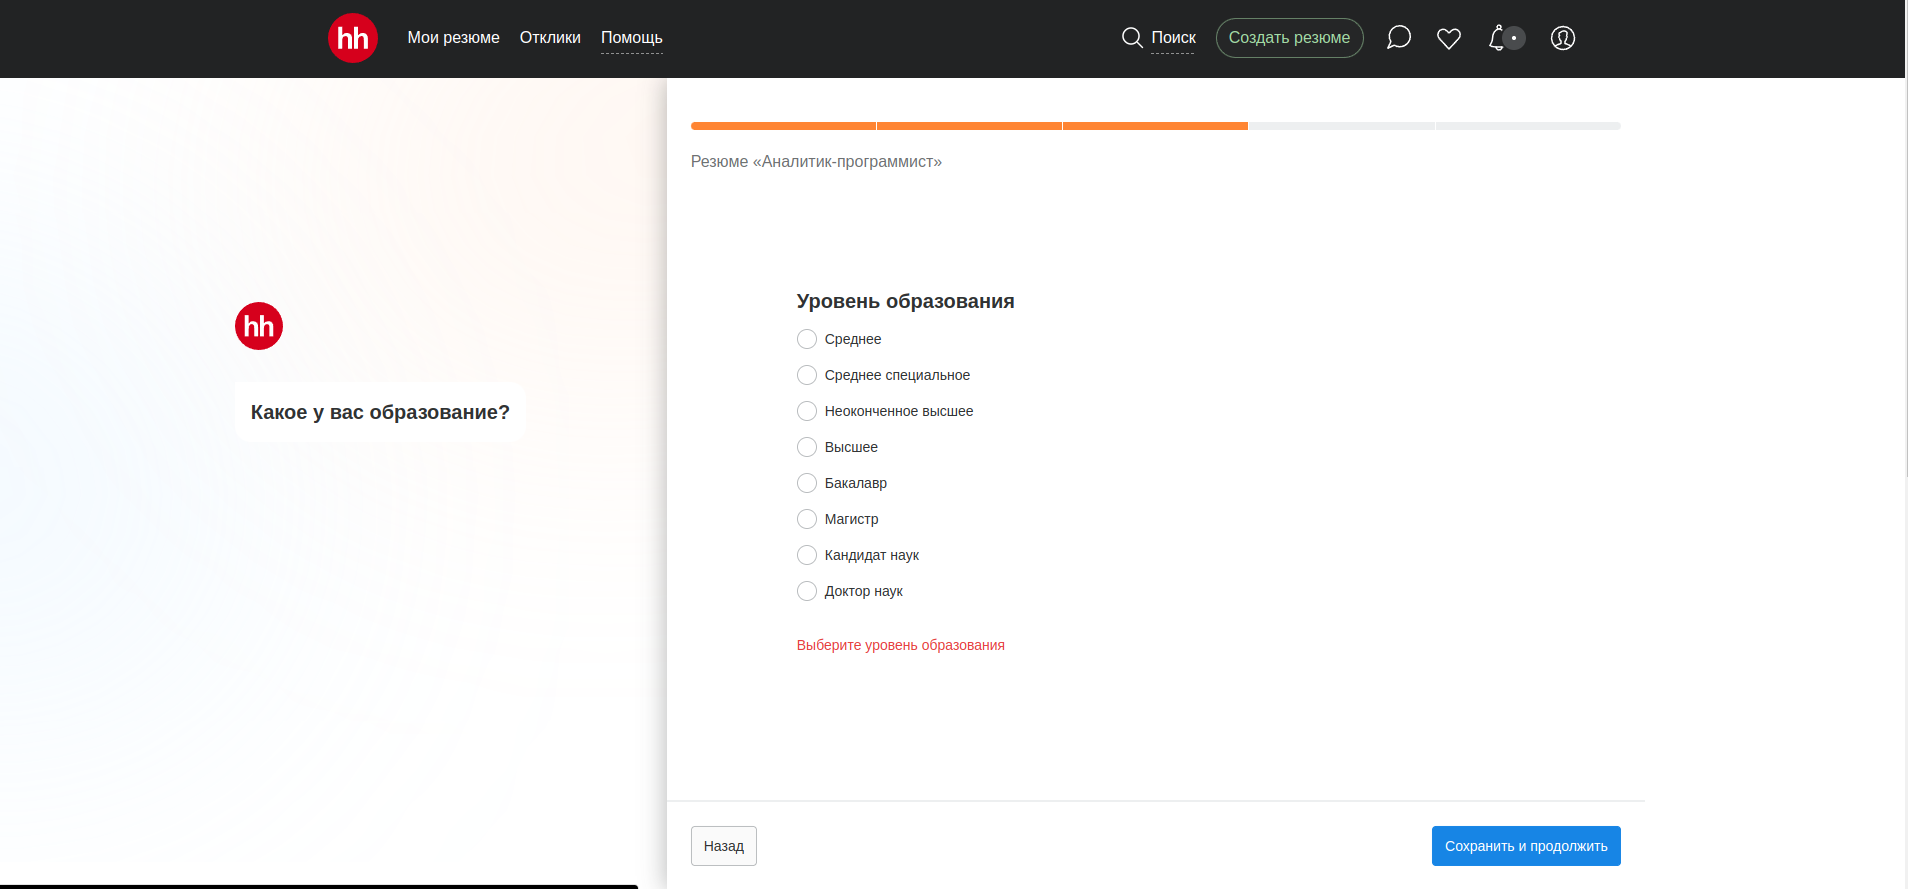

In [40]:
df = df.dropna(subset=['education_level'])

В строке ***expected_salary*** отсутствуют некторые значения, вероятно человек не знает на какую заработную плату ему рассчитывать

Два варианта: выбросить эти данные или заполнить их медианой ожидаемой зарплатой по данной специальности (***profession***)

In [41]:
print(df.groupby(['profession']).agg({'expected_salary': ['median']}))
# решили выбросить
## 2% выбрасываем
df = df.dropna(subset=['expected_salary'])

                                            expected_salary
                                                     median
profession                                                 
SMM-менеджер, контент-менеджер                      40000.0
Администратор                                       50000.0
Аналитик                                            70000.0
Бухгалтер                                           55000.0
Водитель                                            65000.0
...                                                     ...
Финансовый менеджер                                 80000.0
Фитнес-тренер, инструктор тренажерного зала         60000.0
Экономист                                           60000.0
Юрисконсульт                                        60000.0
Юрист                                               70000.0

[68 rows x 1 columns]


In [42]:
## work_schedule
df.work_schedule.unique()
# Out: ['full_day', 'remote', 'flexible', 'shift', nan]
## 1% выбрасываем
df = df.dropna(subset=['work_schedule'])

Ничего путёвого в ***resume_skills_list*** нет

In [43]:
df.resume_skills_list.nunique()
# Out: 132682
df = df.dropna(subset=['resume_skills_list'])

Есть вариант предсказать ***compensation_from*** для данной вакансии (***vacancy_id***): берем минимальное занчение ***compensation_from*** для профессиии данной вакансии. <br>
**PS: предсказать очень сложно, нужно учитывать регион вакансии, график**

In [44]:
# решили просто удалить, чтобы были полные данные
df = df.dropna(subset=['compensation_from'])

In [45]:
df = df.drop(columns=['compensation_to'])

In [48]:
df = df.reset_index(drop=True)
df.info()
# Всего 79981 строк было удалено (16%), 420019 строк осталось (84%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420019 entries, 0 to 420018
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   topic_id                 420019 non-null  object 
 1   topic_creation_date      420019 non-null  object 
 2   initial_state            420019 non-null  object 
 3   final_state              420019 non-null  object 
 4   resume_id                420019 non-null  object 
 5   resume_creation_date     420019 non-null  object 
 6   profession               420019 non-null  object 
 7   gender                   420019 non-null  object 
 8   year_of_birth            420019 non-null  int64  
 9   resume_region            420019 non-null  object 
 10  education_level          420019 non-null  object 
 11  expected_salary          420019 non-null  float64
 12  relocation_status        420019 non-null  object 
 13  business_trip_readiness  420019 non-null  object 
 14  work

## Преобразование

In [122]:
df['applicant_age'] = 0
# создадим переменную возраста соискателя
# а именно это возраст, который будет у соискателя к концу 2023 года
for index, row in df.iterrows():
    birth_year = row['year_of_birth']
    df.loc[index, 'applicant_age'] = 2023 - int(birth_year)

## Выбросы

In [123]:
# проверяем временной промежуток для topic_creation_date
dates = df.topic_creation_date.unique().tolist()
years = set()
months = set()
days = set()
for elem in dates:
    years.add(elem[0:4])
    months.add(elem[5:7])
    days.add(elem[8:10])
print(sorted(years))
print(sorted(months))
print(sorted(days))
# всё норм
# resume_creation_date и vacancy_creation_date проверять не нужно
# резюме и вакансии могли быть созданы и раньше

['2023']
['06', '07', '08']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


0.668129470694811

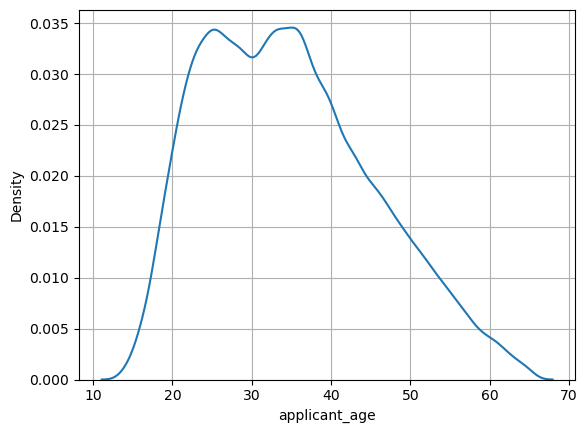

In [124]:
# а вот диаграмма распределения возрастовсоискателей 
unique_resumes = df.drop_duplicates(subset=['resume_id'])
sns.kdeplot(unique_resumes, x='applicant_age')
plt.grid()
unique_resumes[(unique_resumes.applicant_age >= 20)
               & (unique_resumes.applicant_age <= 40)].shape[0] / unique_resumes.shape[0]
# Out: 0.66545
# 67% соискателей имеют возраст от 20 до 40

<Axes: ylabel='applicant_age'>

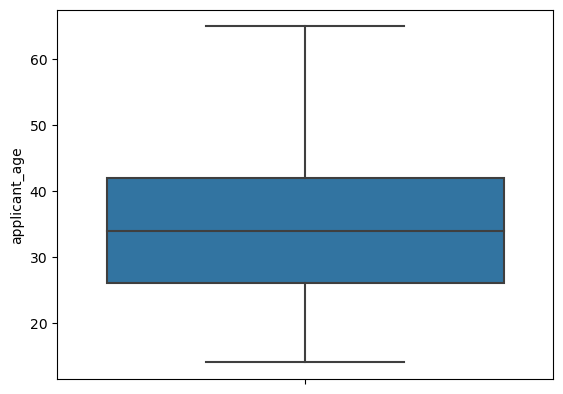

In [125]:
sns.boxplot(unique_resumes, y='applicant_age', )

(159511, 26)
      applicant_age
max        65.00000
mean       34.70545
min        14.00000


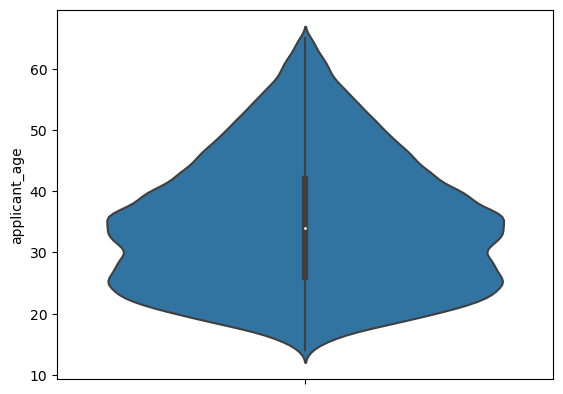

In [126]:
print(unique_resumes.shape)
iqr = unique_resumes.applicant_age.quantile(0.75) - unique_resumes.applicant_age.quantile(0.25)
unique_resumes[
    (unique_resumes.applicant_age < unique_resumes.applicant_age.quantile(0.75) + 1.5 * iqr)
    & (unique_resumes.applicant_age > unique_resumes.applicant_age.quantile(0.25) - 1.5 * iqr)
]
sns.violinplot(unique_resumes[
    (unique_resumes.applicant_age < unique_resumes.applicant_age.quantile(0.75) + 1.5 * iqr)
    & (unique_resumes.applicant_age > unique_resumes.applicant_age.quantile(0.25) - 1.5 * iqr)
], y='applicant_age')
print(unique_resumes[
    (unique_resumes.applicant_age < unique_resumes.applicant_age.quantile(0.75) + 1.5 * iqr)
    & (unique_resumes.applicant_age > unique_resumes.applicant_age.quantile(0.25) - 1.5 * iqr)
].agg({'applicant_age': ['max', 'mean', 'min']}))
#           applicant_age
# max       65.000000
# mean      34.706463
# min       14.000000

In [127]:
df = df[(df.applicant_age >= 14 ) & (df.applicant_age <= 65)]

In [194]:
df.resume_region.unique().tolist()
# тут нема Севостополя (город ФЗ)
df.vacancy_region.unique().tolist()
# тут нема Херсонской и еще чего то

['Москва',
 'Московская область',
 'Пензенская область',
 'Ивановская область',
 'Краснодарский край',
 'Новосибирская область',
 'Приморский край',
 'Брянская область',
 'Чувашская Республика',
 'Республика Башкортостан',
 'Свердловская область',
 'Калужская область',
 'Республика Хакасия',
 'Нижегородская область',
 'Челябинская область',
 'Новгородская область',
 'Санкт-Петербург',
 'Воронежская область',
 'Самарская область',
 'Республика Татарстан',
 'Астраханская область',
 'Ленинградская область',
 'Ростовская область',
 'Липецкая область',
 'Иркутская область',
 'Белгородская область',
 'Тюменская область',
 'Красноярский край',
 'Архангельская область',
 'Республика Марий Эл',
 'Ульяновская область',
 'Ямало-Ненецкий АО',
 'Волгоградская область',
 'Кировская область',
 'Пермский край',
 'Забайкальский край',
 'Ярославская область',
 'Томская область',
 'Кемеровская область',
 'Тамбовская область',
 'Оренбургская область',
 'Саратовская область',
 'Смоленская область',
 'Волог

In [120]:
df[df.education_level == 'doctor']
# забавно, что в наше время, на профессию разнорабочего, бармена,
# уборщика и фитнес-инструктора приглашают людей с докторской степенью

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,work_experience_months,resume_skills_list,vacancy_id,vacancy_creation_date,vacancy_region,work_schedule_required,vacancy_employment_type,compensation_from,vacancy_skills_list,applicant_age


In [121]:
# Пока что решили удалить эти несчастные 35 строк
df = df[df.education_level != 'doctor']

<Axes: xlabel='expected_salary', ylabel='Density'>

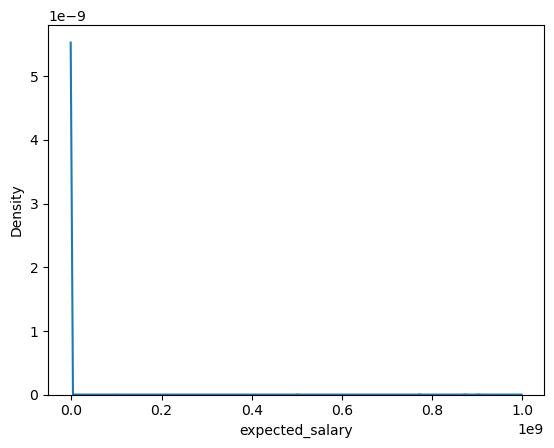

In [149]:
# что с этим дееееелаааать??
sns.kdeplot(unique_resumes, x='expected_salary')

In [150]:
df.relocation_status.unique().tolist()

['not_ready', 'possible', 'desirable']

In [151]:
df.business_trip_readiness.unique().tolist()

['never', 'ready', 'sometimes']

In [197]:
df.resume_employment_type.unique().tolist()
# Out: ['full', 'project', 'part', 'probation', 'volonteer']
# full - полная занятость
# project - проектная работа
# part - частичная занятость
# probation - видимо что то типа стажировки
# volonteer - волонтерская деятельность
df.resume_employment_type.value_counts()
# resume_employment_type
# full         354663
# part          45875
# project       11635
# probation      5102
# volonteer       714
# Name: count, dtype: int64
df.vacancy_employment_type.unique().tolist()
# Out: ['full', 'part', 'probation', 'project', 'volonteer']
df.resume_employment_type.value_counts()
# resume_employment_type
# full         354663
# part          45875
# project       11635
# probation      5102
# volonteer       714
# Name: count, dtype: int64

resume_employment_type
full         354663
part          45875
project       11635
probation      5102
volonteer       714
Name: count, dtype: int64

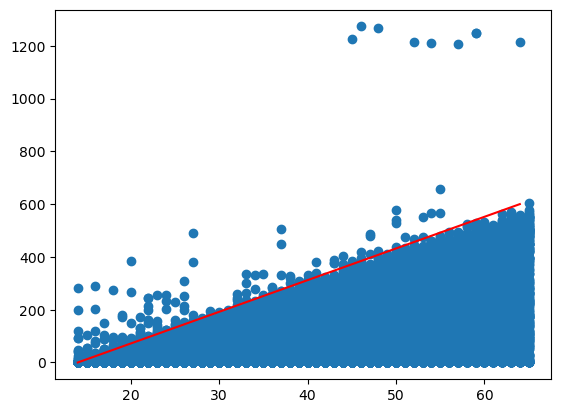

In [182]:
def F(x):
    return 12 * (x - 14)
x = list(range(14, 65, 1))
y = list(map(F, x))
plt.scatter(unique_resumes['applicant_age'], unique_resumes['work_experience_months'])
plt.plot(x, y, 'r')
# Пока не знаем как задать эту прямую

Outliers count: 240
Not outliers count: 159271


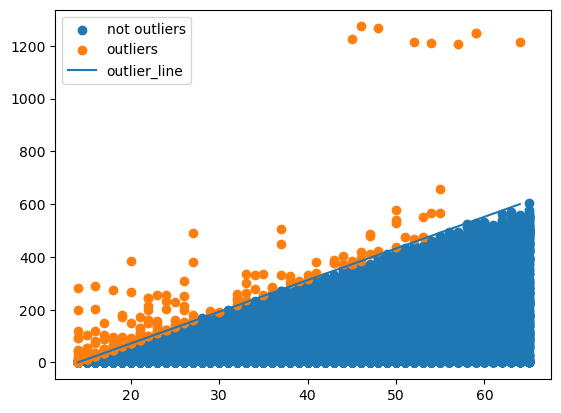

In [188]:
unique_resumes_cp = unique_resumes.copy()
outliers = unique_resumes_cp[unique_resumes_cp.work_experience_months > unique_resumes_cp.applicant_age.apply(F)]
not_outliers = unique_resumes_cp[unique_resumes_cp.work_experience_months <= unique_resumes_cp.applicant_age.apply(F)]
plt.scatter(not_outliers['applicant_age'], not_outliers['work_experience_months'], label='not outliers')
plt.scatter(outliers['applicant_age'], outliers['work_experience_months'], label='outliers')
plt.plot(x, y, label='outlier_line')
plt.legend()
print(f'Outliers count: {outliers.shape[0]}')
print(f'Not outliers count: {not_outliers.shape[0]}')

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,work_experience_months,resume_skills_list,vacancy_id,vacancy_creation_date,vacancy_region,work_schedule_required,vacancy_employment_type,compensation_from,vacancy_skills_list,applicant_age
190,3371744124c0,2023-07-31 00:00:00.000,response,invitation,65815t1t,2017-07-19 00:00:00.000,"Менеджер по продажам, менеджер по работе с кли...",female,1980,Москва,...,284,"['1c: бухгалтерия', '1с: предприятие 8', '1с: ...",84085168,2023-07-26 00:00:00.000,Москва,full_day,full,500000.0,"['навыки презентации', 'ориентация на результа...",43
281,341291740c6412,2023-06-07 00:00:00.000,invitation,invitation,1bb6080b8,2020-05-12 00:00:00.000,"Менеджер по продажам, менеджер по работе с кли...",female,1990,Санкт-Петербург,...,147,"['ведение переговоров', 'техники продаж', 'соп...",801t1851,2023-05-08 00:00:00.000,Санкт-Петербург,full_day,full,500000.0,"['деловая переписка', 'ведение переговоров', '...",33
821,b0396639c96,2023-08-21 00:00:00.000,response,response,166085gk,2022-05-04 00:00:00.000,"Менеджер по продажам, менеджер по работе с кли...",male,2003,Санкт-Петербург,...,13,"['работа с жалобами клиентов', 'ответственност...",84tbb1k5,2023-08-11 00:00:00.000,Санкт-Петербург,full_day,full,500000.0,"['организация встреч', 'навыки продаж', 'b2c п...",20
1039,b1647004120,2023-08-29 00:00:00.000,response,response,11t16k6t4,2019-06-15 00:00:00.000,"Менеджер по продажам, менеджер по работе с кли...",male,1993,Нижегородская область,...,50,"['планирование продаж', 'проведение презентаци...",84k61t26,2023-08-08 00:00:00.000,Москва,remote,full,700000.0,"['первичная недвижимость', 'брокер', 'агентски...",30
1609,b0964120060,2023-08-24 00:00:00.000,response,invitation,20144f2t,2023-05-26 00:00:00.000,"Менеджер по продажам, менеджер по работе с кли...",male,2001,Москва,...,25,"['коммуникативные навыки', 'проведение презент...",ktt0b606,2023-04-28 00:00:00.000,Москва,full_day,full,1500000.0,[None],22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391195,3341274129969396,2023-07-02 00:00:00.000,response,discard,162b44kt4,2022-02-11 00:00:00.000,"Программист, разработчик",male,2002,Санкт-Петербург,...,18,"['go', 'php', 'react', 'clickhouse', 'postgres...",81568061,2023-06-05 00:00:00.000,Санкт-Петербург,full_day,project,800000.0,"['react', 'программирование', 'английский язык...",21
397144,3393310b4,2023-08-14 00:00:00.000,response,response,46842l2,2015-11-10 00:00:00.000,Руководитель отдела продаж,male,1973,Москва,...,361,"['бюджетирование', 'управление персоналом', 'р...",850b4b15,2023-08-14 00:00:00.000,Нижегородская область,full_day,full,500000.0,[None],50
397200,34129194164120,2023-06-07 00:00:00.000,response,response,6kt8kb68,2017-09-12 00:00:00.000,Руководитель отдела продаж,male,1979,Москва,...,212,"['работа с жалобами клиентов', 'аналитика прод...",80k28k20,2023-05-19 00:00:00.000,Москва,full_day,full,1000000.0,[None],44
409522,3396412993394,2023-08-08 00:00:00.000,response,discard,1tl26b46,2023-01-26 00:00:00.000,Руководитель отдела продаж,male,1974,Вологодская область,...,320,"['ответственность', 'организаторские навыки', ...",84011425,2023-07-25 00:00:00.000,Костромская область,full_day,full,500000.0,"['аналитика продаж', 'активные продажи', 'навы...",49


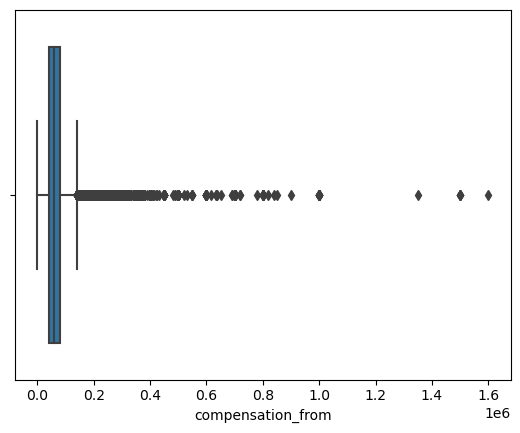

In [202]:
unique_vacancies = df.drop_duplicates(subset=['vacancy_id'])
sns.boxplot(unique_vacancies, x='compensation_from')
unique_vacancies[unique_vacancies.compensation_from > 400000]
# хз че делать с этим

## Переименовали одну переменную

In [47]:
df = df.rename(columns={'work_schedule.1': 'work_schedule_required'})

In [ ]:
df['succesful_topic'] =  

# Сохранение

In [104]:
df.to_csv('Processed-hh-ru.csv', index=False)